# Imports

In [1]:
import pandas                as pd
import numpy                 as np
import matplotlib.pyplot     as plt
import seaborn               as sns
from math                    import sqrt
from sklearn.linear_model    import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics         import r2_score, mean_squared_error, mean_absolute_error 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing   import StandardScaler
from IPython.core.display    import display, HTML
from IPython.display         import display_html
sns.set(style = "white", palette = "husl")
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

# Table Of Contents

-----

1. [Reading In The Data](#Reading-In-The-Data)
    - [Overview](#Overview)

-----

2. [Feature Engineering](#Feature-Engineering)
    - [Transforming Numeric Data](#Transforming-Numeric-Data)
    - [Creating Segmental Features](#Creating-Segmental-Features)
    
-----

3. [Modeling](#Modeling)
    - [Functions](#Functions)
    - [Linear Regression](#Linear-Regression)
    - [Ridge](#Ridge)
    - [LASSO](#LASSO)
    - [ElasticNetCV](#ElasticNetCV)
    
-----

4. [Model Evaluation](#Model-Evaluation)

# Reading In The Data

In [2]:
mri = pd.read_csv("../Data/mri_cleaned.csv")

## Overview

In [3]:
mri.head()

,sex,age,hypertension,hyperlipidemia,diabetes,lvedv,lvesv,lv_wall_thickness,lvef,aortic_stenosis,...,mis_ischemia,mi_ischemia,mil_ischemia,mal_ischemia,aa_ischemia,as_ischemia,ai_ischemia,al_ischemia,smoker_status_former,smoker_status_never
0,1,37,0,0,0,613,501,0,18,0,...,0,0,0,0,0,0,0,0,0,1
1,1,74,0,1,0,569,492,1,14,0,...,0,0,0,0,0,1,0,1,0,1
2,1,78,1,1,1,564,500,0,11,0,...,1,1,0,0,1,1,0,0,0,1
3,1,61,0,1,0,531,435,1,18,0,...,0,0,0,0,0,0,0,0,0,1
4,1,53,0,0,0,522,408,0,21,0,...,0,0,0,0,0,0,0,0,0,0


The `smoker_status` column is still in the data, but we will not needing the column for the models because we turned it into a pair of dummy columns so we will drop the column here.

In [4]:
# Checking the shape of the data

print(f"The shape of the dataset is: {mri.shape}")

The shape of the dataset is: (6417, 48)


In [5]:
# Summary of column data types

mri.dtypes.value_counts()

int64    48
dtype: int64

# Feature Engineering

## Transforming Numeric Data

There are only four numeric columns in the data set: `age`, `lvesv`, `lvedv`, `lvef`.  Of the four, only `lvef` does not have any kind of a normal distribution: `age` is close to normally distributed, while `lvesv` and `lvedv` are log-normally distributed.

We cannot do anything to `lvedv` because that is my target variable, but we can take the log of `lvesv` (in this case the natural log).  We also tried squaring `age` but that did not affect the distribution in the way we hoped it would.

In [6]:
# Take the natural log of `lvesv`.
# We chose to make it it's own column rather
# than overwrite the column.

mri["lvesv_log"] = mri["lvesv"].apply(lambda x: np.log(x))

In [7]:
print(f"The shape of the dataset is: {mri.shape}")

The shape of the dataset is: (6417, 49)


[Top](#Table-Of-Contents)

## Creating Segmental Features

Because the model attempts to predict the end diastolic volume, we want it to be as accurate as it can be.  As part of that, we will try to use many combinations of features in an attempt to achieve high accuracy.

The data have 34 columns that we wish to engineer: a column measuring scarification and a column measuring ischemia.  Because there are so many of them, we felt the need to experiment with how they are passed into the model.  We are unable to create interaction columns, because there are zeros.  Instead, we elected to create segmental columns by summing similar columns together: we will compare the model's performance with the originals and with the segmental columns.

We used this image to guide our create of segmental columns:

<img src = "../Images/cardiac-segmentation-for-cardiac-perfusion-defects.jpg" alt = "Cardiac Segmentation" height = 750 width = 750>

Case courtesy of Dr Hamid Chalian, <a href="https://radiopaedia.org/">Radiopaedia.org</a>. From the case <a href="https://radiopaedia.org/cases/47102">rID: 47102</a>

In [8]:
# Creating columns based off of the red, blue, green, and yellow
# I'm combining the apex and apical regions because there is only
# one region in the apex.

# New columns for scar tissue

mri["basal_he"]  = mri["ba_he"] + mri["bas_he"] + mri["bis_he"] \
                   + mri["bi_he"] + mri["bil_he"] + mri["bal_he"]
mri["mid_he"]    = mri["ma_he"] + mri["mas_he"] + mri["mis_he"] \
                   + mri["mi_he"] + mri["mil_he"] + mri["mal_he"]
mri["apical_he"] = mri["aa_he"] + mri["as_he"] + mri["ai_he"] \
                   + mri["al_he"] + mri["apex_he"]

# New columns for ischemia

mri["basal_ischemia"]  = mri["ba_ischemia"] + mri["bas_ischemia"] + mri["bis_ischemia"] \
                         + mri["bi_ischemia"] + mri["bil_ischemia"] + mri["bal_ischemia"]
mri["mid_ischemia"]    = mri["ma_ischemia"] + mri["mas_ischemia"] + mri["mis_ischemia"] \
                         + mri["mi_ischemia"] + mri["mil_ischemia"] + mri["mal_ischemia"]
mri["apical_ischemia"] = mri["aa_ischemia"] + mri["as_ischemia"] + mri["ai_ischemia"] \
                         + mri["al_ischemia"]

print(f"The shape of the dataset is: {mri.shape}")

The shape of the dataset is: (6417, 55)


[Top](#Table-Of-Contents)

It will be easier when modeling to have two data sets: one with the original features and one with the features I engineered.


In [9]:
# Defining the original dataframe

mri_org = mri.drop(labels = ["lvesv_log", "basal_he", "mid_he",
                             "apical_he", "basal_ischemia",
                             "mid_ischemia", "apical_ischemia"],
                   axis = 1)

# Defining the dataframe with only new features

mri_eng = mri.drop(labels = ['lvesv', 'ba_he', 'bas_he', 'bis_he','bi_he', 
                             'bil_he', 'bal_he', 'ma_he', 'mas_he', 'mis_he', 
                             'mi_he', 'mil_he','mal_he', 'aa_he', 'as_he', 
                             'ai_he', 'al_he', 'apex_he', 'ba_ischemia',
                             'bas_ischemia', 'bis_ischemia', 'bi_ischemia', 
                             'bil_ischemia','bal_ischemia', 'ma_ischemia', 
                             'mas_ischemia', 'mis_ischemia','mi_ischemia', 
                             'mil_ischemia', 'mal_ischemia', 'aa_ischemia', 
                             'as_ischemia', 'ai_ischemia', 'al_ischemia'],
                   axis = 1)

# Checking to make sure the two have different numbers of columns

print(f"The shape of the dataframe with original features is: {mri_org.shape}")
print(f"The shape of the dataframe with new features is     : {mri_eng.shape}")

The shape of the dataframe with original features is: (6417, 48)
The shape of the dataframe with new features is     : (6417, 21)


[Top](#Table-Of-Contents)

# Modeling

Before we can start modeling, we have to perform a train-test split.  A train-test split allows us to train our data on one subset of the dataframe and train on another subset.

Since I have two versions of the dataframe, I will have to train-test split on both.

In [10]:
# Setting up my X and y variables for the original

X  = mri_org.drop("lvedv", axis = 1)
y  = mri_org["lvedv"]

# Setting up my X and y variables for the new

X_eng = mri_eng.drop("lvedv", axis = 1)
y_eng = mri_eng["lvedv"]

In [11]:
# Train-test splitting mri_og

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    random_state = 42,
                                                    test_size    = 0.25) 

# Train-test splitting mri_new

X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(X_eng, 
                                                                    y_eng,
                                                                    random_state = 42,
                                                                    test_size    = 0.25) 

## Functions

In [12]:
# Formula to generate an adjusted r^2 score for
# my model evaluation function in the next cell

def r2_adj(X, y_true, y_predicted):
    r2          = r2_score(y_true, y_predicted)
    numerator   = (1 - r2) * (len(y) - 1)
    denominator = (len(y) - len(X.columns)) - 1
    quotient    = numerator / denominator
    r2_adj      = 1 - quotient
    return r2_adj

The `model_evaluation` function has four metrics:
* r<sup>2</sup> to measure variance in `y` caused by the `X` variables;
* adjusted r<sup>2</sup> to measure the same, but weighted for the number of features;
* root mean squared error (RMSE) to measure the difference between my predicted values and the actual values;
* mean absolute error (MAE) to measure the absolute mean error (this method is less sensitive to outliers).

In [13]:
def model_evaluation(X, y_true, y_predicted):
    rmse = sqrt(mean_squared_error(y_true, y_predicted))
    mae  = mean_absolute_error(y_true, y_predicted)
    r2   = r2_score(y_true, y_predicted)
    print(f"The root mean squared error is : {rmse}")
    print(f"The mean absolute error is     : {mae}")
    print(f"The r2 score is                : {r2}")
    print(f"The adjusted r2 score is       : {r2_adj(X, y_true, y_predicted)}")

In [14]:
# This is the same as the cell above, but lacking the adjusted r^2 score
# because after standard scaling the `X` variables the columns are lost.

def model_evaluation_nor2adj(y_true, y_predicted):
    rmse = sqrt(mean_squared_error(y_true, y_predicted))
    mae  = mean_absolute_error(y_true, y_predicted)
    r2   = r2_score(y_true, y_predicted)
    print(f"The root mean squared error is : {rmse}")
    print(f"The mean absolute error is     : {mae}")
    print(f"The r2 score is                : {r2}")

In [15]:
# This allows me to display the dataframes of the linear regression
# coefficients side-by-side to save space.

def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table', 'table style="display:inline"'), raw = True)

[Top](#Table-Of-Contents)

## Linear Regression

I chose to start with linear regression because it is the simplest of the regression models and allows for the model to be interpretable.

### Original Set

The original set is the dataframe with its original 48 columns.

In [16]:
# Instantiating the linear regression

lr = LinearRegression()

In [17]:
# Fitting the linear regression to the original
# (non-engineered) subset

lr.fit(X_train, y_train);

In [18]:
# Generating my predictions

lr_preds = lr.predict(X_test)

In [19]:
# Evaluating my original set

model_evaluation(X_test, y_test, lr_preds)

The root mean squared error is : 17.474492744600283
The mean absolute error is     : 12.896847595997924
The r2 score is                : 0.9237493878185266
The adjusted r2 score is       : 0.9231866968509447


In [20]:
# Creating a dataframe makes looking the coefficients easier

lin_reg_org = pd.DataFrame(data  = lr.coef_,
                           index = X_test.columns,
                           columns = ["Lin_Reg_Org"])

In [21]:
# Displaying the head and tail side-by-side to show the strongest
# and weakest variables

head = lin_reg_org.sort_values(by = "Lin_Reg_Org", ascending = False).head()
tail = lin_reg_org.sort_values(by = "Lin_Reg_Org", ascending = False).tail()

display_side_by_side(head,tail)

,Lin_Reg_Org
sex,10.864849
smoker_status_former,3.329839
smoker_status_never,3.101885
mil_ischemia,1.894495
lvef,1.755295
,Lin_Reg_Org
mas_ischemia,-1.323619
hyperlipidemia,-1.667128
al_ischemia,-1.739566
ba_ischemia,-2.837152


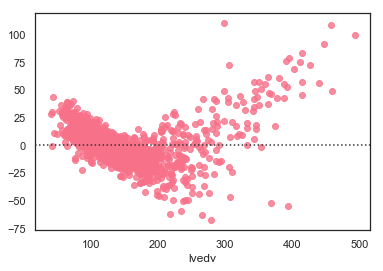

In [22]:
# Plotting the residuals (difference between the predicted and the actual)

sns.residplot(y_test, lr_preds);

[Top](#Table-Of-Contents)

### Engineered Subset

The engineered subset is the dataframe but with the features we engineered instead of the original 34 segmental features.

In [23]:
# Instantiating the linear model

lr_2 = LinearRegression()

In [24]:
# Fitting the linear regression to the subset
# with the features I engineered

lr_2.fit(X_train_eng, y_train_eng);

In [25]:
# Generating my predictions

lr_2_preds  = lr_2.predict(X_test_eng)

In [26]:
# Evaluating my new set

model_evaluation(X_test_eng, y_test_eng, lr_2_preds)

The root mean squared error is : 23.111112718046606
The mean absolute error is     : 15.234989524246423
The r2 score is                : 0.8666245521501372
The adjusted r2 score is       : 0.8662074932137712


In [27]:
# It is easier to view the coefficients in a df

lin_reg_eng = pd.DataFrame(data  = lr_2.coef_,
                           index = X_test_eng.columns,
                           columns = ["Lin_Reg_Eng"])

In [28]:
head = lin_reg_eng.sort_values(by = "Lin_Reg_Eng", ascending = False).head()
tail = lin_reg_eng.sort_values(by = "Lin_Reg_Eng", ascending = False).tail()

display_side_by_side(head,tail)

,Lin_Reg_Eng
lvesv_log,129.015341
mitral_reg,5.307152
lvef,2.253598
hypertension,2.104900
lv_wall_thickness,2.094055
,Lin_Reg_Eng
basal_he,-0.205841
smoker_status_never,-1.111246
diabetes,-1.244056
mid_ischemia,-1.261124


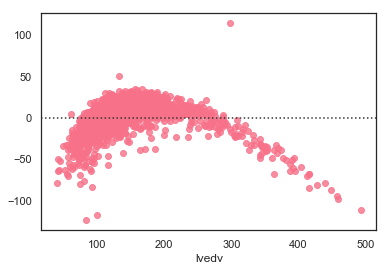

In [29]:
# Looking at the residuals

sns.residplot(y_test_eng, lr_2_preds);

[Top](#Table-Of-Contents)

## Ridge

Ridge regression works by imposing a penalty on the coefficients: it uses the $\ell$<sub>2</sub> regularization which shrinks thems towards 0 and effectively removes features without actually doing so and reduces the overall complexity.

----

Because the features can be so strongly affected by $\alpha$ it is important to have them all be on the same scale.  To do this, we used `StandardScaler`.

In [30]:
# Instantiating the standard scaler

ss = StandardScaler()

In [31]:
# Transforming the original set

# Fit-transforming my X_train features

X_train_ss     = ss.fit_transform(X_train)

# Transforming my X_test variables

X_test_ss  = ss.transform(X_test)

In [32]:
# Transforming the engineered set

# Fit-transforming my X_train_eng features

X_train_eng_ss = ss.fit_transform(X_train_eng)

# Transforming my X_test_eng features

X_test_eng_ss = ss.transform(X_test_eng)

### Original Set

In [33]:
# Instantiating the ridge model

ridge = RidgeCV()

In [34]:
# Fitting the ridge model to the training data

ridge.fit(X_train_ss, y_train);

In [35]:
# Generating Predictions

ridge_preds = ridge.predict(X_test_ss)

In [36]:
# Evaluating the model
# There is no adjusted r2 score because there are 
# no columns after the scaling process

model_evaluation_nor2adj(y_test, ridge_preds)

The root mean squared error is : 17.4627798093733
The mean absolute error is     : 12.93357119857244
The r2 score is                : 0.9238515732348865


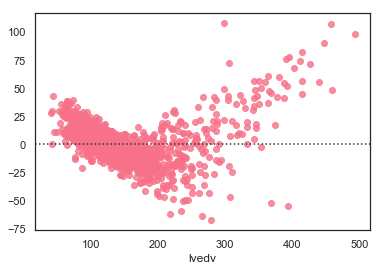

In [37]:
sns.residplot(y_test, ridge_preds);

### Engineered Subset

In [38]:
# Instantiating the ridge model

ridge_2 = RidgeCV()

In [39]:
# Fitting the ridge model to the data
# with engineered features

ridge_2.fit(X_train_eng_ss, y_train_eng);

In [40]:
# Generating Predictions

ridge_2_preds = ridge_2.predict(X_test_eng_ss)

In [41]:
model_evaluation_nor2adj(y_test_eng, ridge_2_preds)

The root mean squared error is : 23.11285690232428
The mean absolute error is     : 15.236579363787632
The r2 score is                : 0.8666044198319497


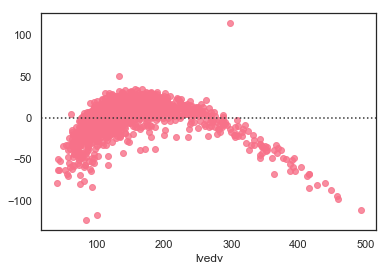

In [42]:
sns.residplot(y_test_eng, ridge_2_preds);

[Top](#Table-Of-Contents)

## LASSO

LASSO (Least Absolute Shrinkage and Selection Operator) is conceptually similar to Ridge in that it penalizes coefficients, but it uses $\ell$<sub>2</sub> regularization which actually reduces the coefficients of unimportant features to exactly 0.

-----

Like Ridge, the values put into a LASSO model have to be scaled.

In [43]:
# Transforming the original set

# Fit-transforming my X_train features

X_train_ss     = ss.fit_transform(X_train)

# Transforming my X_test variables

X_test_ss  = ss.transform(X_test)

In [44]:
# Transforming the engineered set

# Fit-transforming my X_train_eng features

X_train_eng_ss = ss.fit_transform(X_train_eng)

# Transforming my X_test_eng features

X_test_eng_ss = ss.transform(X_test_eng)

### Original Set

In [45]:
# Instantiating the LASSO model

lasso = LassoCV()

In [46]:
# Fitting the lasso to my training data
# without engineered features

lasso.fit(X_train_ss, y_train)

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [47]:
# Generating predictions

lasso_preds = lasso.predict(X_test_ss)

In [48]:
# Evaluating the model's performance

model_evaluation_nor2adj(y_test, lasso_preds)

The root mean squared error is : 17.452841587008194
The mean absolute error is     : 12.939964432287836
The r2 score is                : 0.9239382220572515


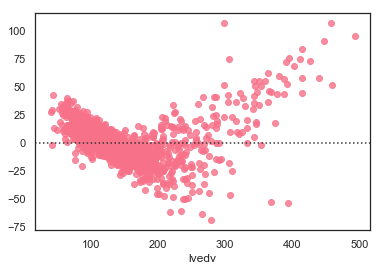

In [49]:
sns.residplot(y_test, lasso_preds);

### Engineered Subset

In [50]:
# Instantiating the lasso model

lasso_2 = LassoCV()

In [51]:
# Fitting the lasso to my training data
# with engineered features

lasso_2.fit(X_train_eng_ss, y_train_eng)

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [52]:
# Generating predictions

lasso_2_preds = lasso_2.predict(X_test_eng_ss)

In [53]:
model_evaluation_nor2adj(y_test_eng, lasso_2_preds)

The root mean squared error is : 23.166184744532803
The mean absolute error is     : 15.294185552657328
The r2 score is                : 0.8659881476740601


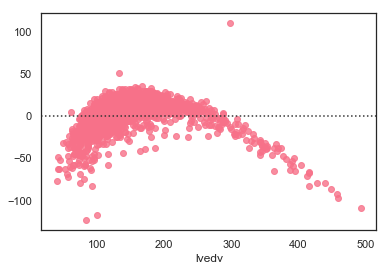

In [54]:
sns.residplot(y_test, lasso_2_preds);

[Top](#Table-Of-Contents)

## ElasticNetCV

Elastic net models are similar to both Ridge _and_ LASSO models: they are a compromise between the $\ell$<sub>1</sub> and$\ell$<sub>2</sub> regularizations.  In practice the model drives down non-significant features but does not remove them entirely.

-----

This method also requires the X variables to be scaled.

### Original Set

In [55]:
# Instantiating the model

enet = ElasticNetCV()

In [56]:
# Fitting the model to the 
# original data set

enet.fit(X_train_ss, y_train)

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


ElasticNetCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
             l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [57]:
# Generating predictions

enet_preds = enet.predict(X_test_ss)

In [58]:
# Evaluating the model's performance

model_evaluation_nor2adj(y_test, enet_preds)

The root mean squared error is : 18.71825193430591
The mean absolute error is     : 14.381573761551651
The r2 score is                : 0.912508722920664


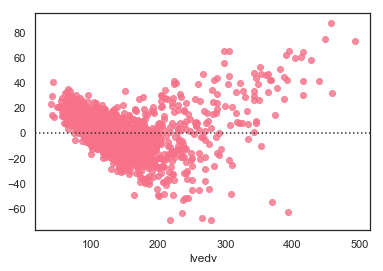

In [59]:
# Plotting the residuals

sns.residplot(y_test, enet_preds);

### Engineered Subset

In [60]:
# Instantiatig the model

enet_2 = ElasticNetCV()

In [61]:
# Fitting the model to the data
# with engineered features

enet_2.fit(X_train_eng_ss, y_train_eng)

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


ElasticNetCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
             l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [62]:
# Generating predictions

enet_2_preds = enet_2.predict(X_test_eng_ss)

In [63]:
# Evaluating the model

model_evaluation_nor2adj(y_test_eng, enet_2_preds)

The root mean squared error is : 24.881057382163224
The mean absolute error is     : 16.691842447714198
The r2 score is                : 0.845413400147587


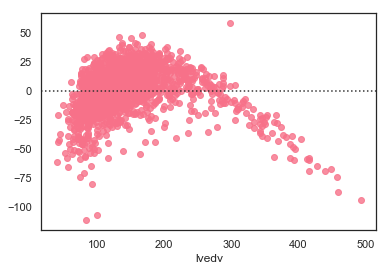

In [64]:
# Plotting the residuals

sns.residplot(y_test, enet_2_preds);

[Top](#Table-Of-Contents)

# Model Evaluation